In [1]:
%%capture
!pip install transformers datasets evaluate albumentations timm
!pip install -U opencv-python accelerate

In [1]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
DATASET_ID = "cppe-5"
cppe5 = load_dataset(DATASET_ID)

In [3]:
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [4]:
cppe5["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

In [5]:
id2label = {i:v for i, v in enumerate(cppe5["train"].features["objects"].feature["category"].names)}
label2id = {v:k for k, v in id2label.items()}

In [6]:
def show_example(ds, split="train", idx=0):
    sample = ds[split][idx]
    img = sample["image"]
    plt.imshow(img)
    ax = plt.gca()
    for i, box in enumerate(sample["objects"]["bbox"]):
        x, y, w, h = box
        ax.add_patch(plt.Rectangle((x,y), w, h, fill=False, color="red"))
        ax.text(x, y, f"{id2label[sample['objects']['category'][i]]}")
    plt.show()

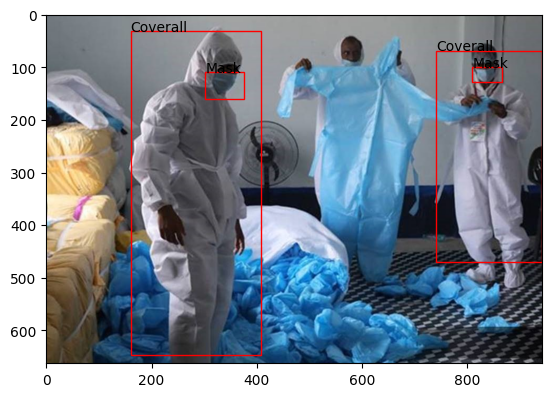

In [8]:
show_example(cppe5)

In [9]:
sizes = [cppe5["train"][idx]["image"].size for idx in range(len(cppe5["train"]))]

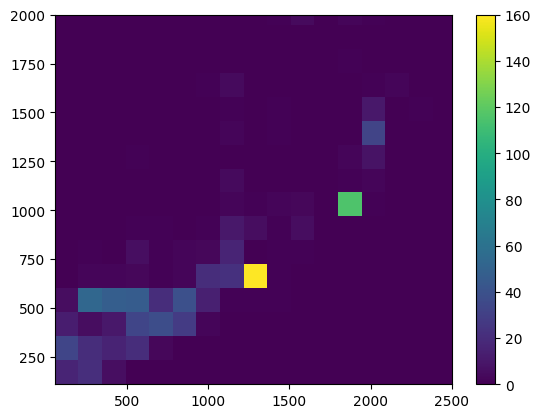

In [10]:
x, y = list(zip(*sizes))
plt.hist2d(x, y, bins=(50, 50))
plt.xlim(right=2500)
plt.ylim(top=2000)
plt.colorbar()
plt.show()

In [7]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

In [8]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [10]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [11]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [16]:
np.array(cppe5["train"][0]["image"]).shape

(663, 943, 3)

In [12]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

{'pixel_values': tensor([[[ 1.2899,  1.2899,  1.2899,  ..., -1.8268, -1.8268, -1.8268],
          [ 1.2899,  1.2899,  1.2899,  ..., -1.8268, -1.8268, -1.8268],
          [ 1.2899,  1.2899,  1.2899,  ..., -1.8097, -1.8097, -1.8097],
          ...,
          [-1.3815, -1.3815, -1.3815,  ..., -1.8439, -1.8439, -1.8439],
          [-1.3644, -1.3644, -1.3644,  ..., -1.8439, -1.8268, -1.8268],
          [-1.3644, -1.3644, -1.3644,  ..., -1.8439, -1.8268, -1.8268]],
 
         [[ 1.7108,  1.7108,  1.7108,  ..., -1.6856, -1.6856, -1.6856],
          [ 1.7108,  1.7108,  1.7108,  ..., -1.6856, -1.6856, -1.6856],
          [ 1.7108,  1.7108,  1.7108,  ..., -1.6681, -1.6681, -1.6681],
          ...,
          [-1.1078, -1.1078, -1.1078,  ..., -1.7031, -1.7031, -1.7031],
          [-1.0903, -1.0903, -1.0903,  ..., -1.7031, -1.6856, -1.6856],
          [-1.0903, -1.0903, -1.0903,  ..., -1.7031, -1.6856, -1.6856]],
 
         [[ 1.8208,  1.8208,  1.8208,  ..., -1.4907, -1.4907, -1.4907],
          [ 

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [14]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True
)

In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor
)

trainer.train()

Step,Training Loss
50,3.676700
100,2.682300
150,2.499600
200,2.268200
250,2.225700
300,2.156400
350,2.129100
400,2.035100
450,2.043500
500,1.884900


TrainOutput(global_step=1250, training_loss=2.034571075439453, metrics={'train_runtime': 2004.3257, 'train_samples_per_second': 4.954, 'train_steps_per_second': 0.624, 'total_flos': 4.7447108971776e+18, 'train_loss': 2.034571075439453, 'epoch': 10.0})

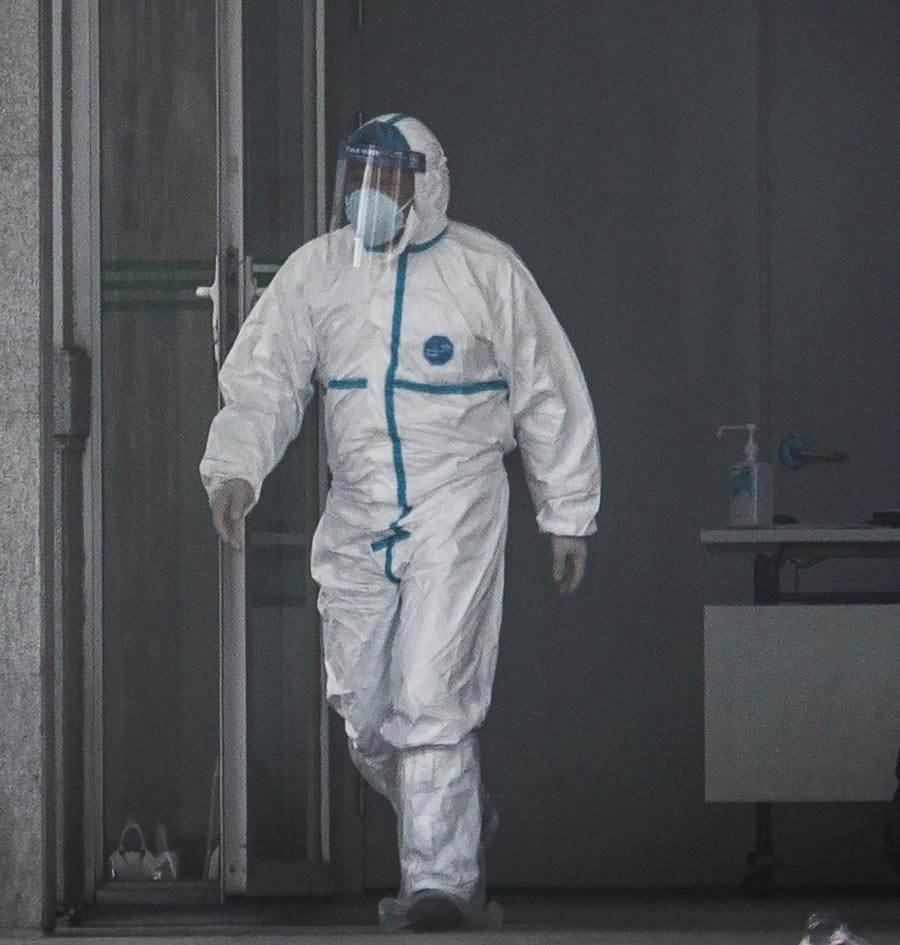

In [21]:
image = cppe5["test"][2]["image"]
image

In [22]:
image_processor = AutoImageProcessor.from_pretrained("andrei-saceleanu/detr-resnet-50_finetuned_cppe5")
model = AutoModelForObjectDetection.from_pretrained("andrei-saceleanu/detr-resnet-50_finetuned_cppe5")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )